# Houskeeping

In [98]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Datagathering and Calculating Fair Value Gaps

In [99]:
TICKER = 'SPY'
LOOKBACK = 10000
HOLDING_PERIOD = 5

def get_data():
    df = yf.download(TICKER)
    df.columns = df.columns.get_level_values(0)
    return df.iloc[-LOOKBACK:, :]

def bull_fvg(df):
    
    df['High_2prev'] = df['High'].shift(2)
    df['Bull_FVG'] = (df['Low'] > df['High_2prev']).astype(int)
    df['Bull_FVG_Val'] = (df['Low'] - df['High_2prev']) * df['Bull_FVG'] / df['Close']

    fvg_subset = df[df['Bull_FVG_Val'] > 0]

    plt.figure(figsize=(6, 6)) 
    plt.hist(fvg_subset['Bull_FVG_Val'], bins=10, color='skyblue', edgecolor='black')
    plt.title('Bullish Fair Value Gaps', fontsize=16)
    plt.xlabel('Fair Value Gap', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

    return df

def bear_fvg(df):
    
    df['Low_2prev'] = df['Low'].shift(2)
    df['Bear_FVG'] = (df['High'] < df['Low_2prev']).astype(int)
    df['Bear_FVG_Val'] = (df['High'] - df['Low_2prev']) * df['Bear_FVG'] / df['Close']

    fvg_subset = df[df['Bear_FVG_Val'] < 0]

    plt.figure()
    plt.hist(fvg_subset['Bear_FVG_Val'], bins=10, color='lightcoral',edgecolor='black')
    plt.title('Bearish Fair Value Gaps', fontsize=16)
    plt.xlabel('Fair Value Gap', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

    return df



# Fair Value Gap Assessment 

Testing if moderate fair value gaps by volume are more effective than looking at all fair value gaps

In [104]:
def assess_bull_FVG(df, holding_period=HOLDING_PERIOD):

    #5 day holding period returns
    df[f'Returns_In_{holding_period}_Periods'] = df['Close'].shift(-holding_period) / df['Close']
    
    fvg_subset = df[df['Bull_FVG_Val'] > 0]
    print(f'{len(fvg_subset)} Bullish FVGs')
    print(f'Bull FVG {holding_period} Period Average returns: {round((fvg_subset[f'Returns_In_{holding_period}_Periods'].mean() - 1) * 100, 2)}%')

    win_rate = (fvg_subset[f'Returns_In_{holding_period}_Periods'] < 1).mean() * 100
    print(f'Bull FVG Win Rate: {round(win_rate, 2)}%')

    # define quantiles
    lower = fvg_subset['Bull_FVG_Val'].quantile(.25)
    upper = fvg_subset['Bull_FVG_Val'].quantile(.75)

    # subset
    fvg_medium_val = fvg_subset[
        (fvg_subset['Bull_FVG_Val'] >= lower) & (fvg_subset['Bull_FVG_Val'] <= upper)
    ]
    print(f'{len(fvg_medium_val)} Medium Sized Bullish FVGs')
    print(f'Medium Bull FVG {holding_period} Period Average returns: {round((fvg_medium_val[f'Returns_In_{holding_period}_Periods'].mean() - 1) * 100, 2)}%')

    win_rate_medium = (fvg_medium_val[f'Returns_In_{holding_period}_Periods'] < 1).mean() * 100
    print(f'Medium Bull FVG Win Rate: {round(win_rate_medium, 2)}%')
    return df

def assess_bear_FVG(df, holding_period=HOLDING_PERIOD):

    #5 day holding period returns
    df[f'Returns_In_{holding_period}_Periods'] = df['Close'].shift(-holding_period) / df['Close']
    
    fvg_subset = df[df['Bear_FVG_Val'] < 0]
    print(f'{len(fvg_subset)} Bearish FVGS')
    print(f'Bear FVG {holding_period} Period Average returns: {round((fvg_subset[f'Returns_In_{holding_period}_Periods'].mean() - 1) * 100, 2)}%')

    win_rate = (fvg_subset[f'Returns_In_{holding_period}_Periods'] > 1).mean() * 100
    print(f'Bear FVG Win Rate: {round(win_rate, 2)}%')


    # define quantiles
    lower = fvg_subset['Bear_FVG_Val'].quantile(.25)
    upper = fvg_subset['Bear_FVG_Val'].quantile(.75)

    # subset
    fvg_medium_val = fvg_subset[
        (fvg_subset['Bear_FVG_Val'] >= lower) & (fvg_subset['Bear_FVG_Val'] <= upper)
    ]
    print(f'{len(fvg_medium_val)} Medium Sized Bearish FVGs')
    print(f'Medium Bear FVG {holding_period} Period Average returns: {round((fvg_medium_val[f'Returns_In_{holding_period}_Periods'].mean() - 1) * 100, 2)}%')

    win_rate_medium = (fvg_medium_val[f'Returns_In_{holding_period}_Periods'] > 1).mean() * 100
    print(f'Medium Bull FVG Win Rate: {round(win_rate_medium, 2)}%')

    return df
    

# Running the Code 

C:\Users\EWD\AppData\Local\Temp\ipykernel_28324\3563268125.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(TICKER)
[*********************100%***********************]  1 of 1 completed


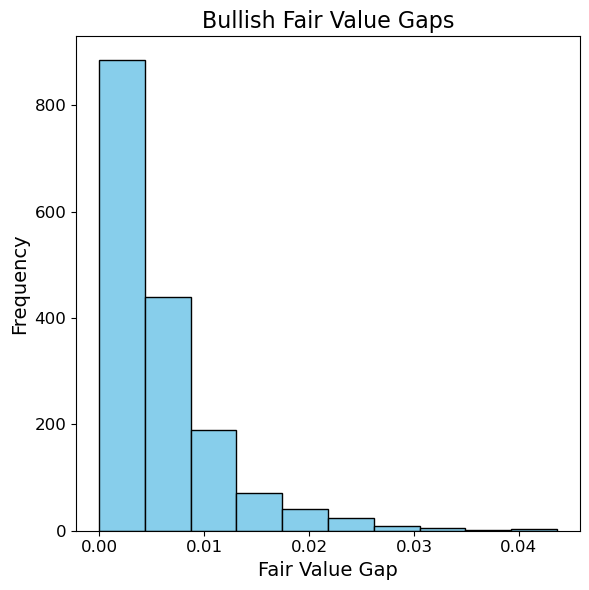

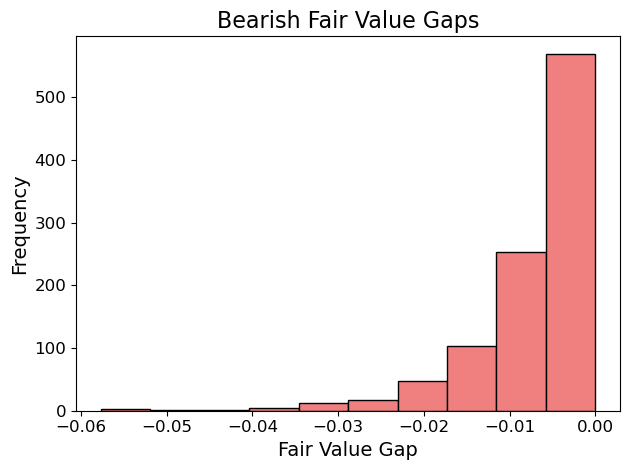

1667 Bullish FVGs
Bull FVG 5 Period Average returns: 0.11%
Bull FVG Win Rate: 42.17%
833 Medium Sized Bullish FVGs
Medium Bull FVG 5 Period Average returns: 0.08%
Medium Bull FVG Win Rate: 44.78%
1012 Bearish FVGS
Bear FVG 5 Period Average returns: 0.46%
Bear FVG Win Rate: 61.26%
506 Medium Sized Bearish FVGs
Medium Bear FVG 5 Period Average returns: 0.36%
Medium Bull FVG Win Rate: 59.49%


In [105]:
def main():
    df = get_data()
    df = bull_fvg(df)
    df = bear_fvg(df)
    df = assess_bull_FVG(df)
    df = assess_bear_FVG(df)

    return df

df = main()

The Bullish FVGs generated 1,667 signals. On average, these signals resulted in a 5-period return of just +0.11%, with a win rate of 42.17%. This means that in most cases, the price did not increase after a bullish FVG appeared. When focusing on medium-sized bullish FVGs (the middle 50% of values), performance was slightly worse, with an average return of +0.08% and a win rate of 44.78%. These results suggest that bullish FVGs, as currently defined, are weak predictors of upward price movement and may not be effective as stand-alone buy signals.

Bearish FVGs behaved in an unexpected way. A total of 1,012 bearish FVG signals produced an average 5-period return of +0.46%, and a win rate of 61.26%. That is, the price tended to go up after a bearish FVG formed. 
Medium-sized bearish FVGs also showed similar behavior, with an average return of +0.36% and a win rate of 59.49%. This suggests that bearish FVGs are acting more like bullish signals 